# Agglomerative Clustering with NYC census tracts data

In [1]:
import datasets
import warnings

warnings.filterwarnings("ignore")

### Retrieve polygon dataset

In [2]:
nyctracts = datasets.get_nyc_census_tracts()

### Visualize polygons on map

In [3]:
from cartoframes.viz import Map, Layer, color_category_style, color_category_legend

nyctracts["county_fips"] = nyctracts.geoid.str[:5]

Layer(nyctracts, 
      style = color_category_style('county_fips'),
      legends = color_category_legend(title="County FIPS")
)

### Calculate Clusters

In [4]:
import time as time
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

X = nyctracts[["latitude", "longitude"]].values

# Compute clustering
ward = AgglomerativeClustering(n_clusters=10).fit(X)

nyctracts["label_unstructured"] = [str(l).zfill(2) for l in ward.labels_]

Layer(nyctracts, 
      color_category_style('label_unstructured')
)

The previous method uses the distances calculated in lat/long space for the linkage 

In [5]:
# Compute structured clustering
from libpysal.weights import Rook

wgt = Rook.from_dataframe(nyctracts)
X = nyctracts[["latitude", "longitude"]].values

In [6]:
ward = AgglomerativeClustering(n_clusters=16, connectivity=wgt.sparse).fit(X)

nyctracts["label_structured_islands"] = [str(l).zfill(2) for l in ward.labels_]

In [7]:
Layer(nyctracts, 
      color_category_style('label_structured_islands',top=16)
)

If there are disjoint areas, like above where there are six disconnected regions, then the [connectivity graph is 'completed'](https://stackoverflow.com/questions/42821622/scikit-learn-agglomerative-clustering-connectivity-matrix) by the Agglomerative clustering algorithm implemented in scikit-learn to add additional linkage to create a single graph.

In [8]:
from splot.libpysal import plot_spatial_weights
import matplotlib.pyplot as plt

wgt = Rook.from_dataframe(nyctracts)

fig, ax = plt.subplots(1, 1, figsize=(18, 24))

plot_spatial_weights(wgt, nyctracts, ax=ax)

(<Figure size 1800x2400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2876507cc0>)

### Disconnected Regions

The warning tells us we have six disconnected regions. We can see from the connectivity graph above that they are:
1. Staten Island
2. Manhattan
3. Bronx
4. Roosevelt Island
5. Brooklyn and Queens
6. Rockaways

To add connectivity in the graph, we will manually add a few bridges to illustrate the concept. The user can add more bridges, tunnels, and/or ferries to see how results are affected by adding more or less connectivity in the graph.

The connections are added as follows:
1. Identify the two geographies that are to be connected
2. Since the PySAL weight object represents a directional graph, we need to list the connection in both directions.
    ```
    {
        id1: [id2],
        id2: [id1]
    }
    ```
3. For cases that a geography is connected to more than one other geography, make sure it is only represented once as a key but added to the list for another geography it is connected to. For example, if `id1` is connected to `id2` and `id3`, but `id2` and `id3` are not connected, the graph would look as follows:
    ```
    {
        id1: [id2, id3],
        id2: [id1],
        id3: [id1]
    }
    ```

In [9]:
# manually-created connections on bridges using db-id
bridge_connections = {
    # Verrazzano-Narrows Bridge (Staten Island <-> Brooklyn)
    4551: [2571],
    2571: [4551],
    # Williamsburg Bridge (Manhattan <-> Brooklyn)
    2923: [3498],
    3498: [2923],
    # Queensborough Bridge (Manhattan <-> Queens)
    3595: [3900],
    3900: [3736, 3595],
    # Roosevelt Island <-> Queens
    3736: [3900],
    # Astoria <-> East Harlem
    3943: [3688],
    3688: [2028, 3943],
    # East Harlem <-> Bronx
    2028: [3688],
    # Northern Manhattan <-> Marble Hill
    3769: [2237],
    2237: [3769],
    # Rockaways
    4411: [3009],
    3009: [4411],
}

# map DB id to row id for use in agglomerative clustering below
index_rownum_mapping = {idx: ridx for ridx, idx in enumerate(nyctracts.cartodb_id)}
mapped_connections = dict()

for k in bridge_connections:
    mapped_connections[index_rownum_mapping[k]] = [
        index_rownum_mapping[v] for v in bridge_connections[k]
    ]

In [10]:
import warnings
from libpysal.weights import w_union, W

# ignore disconnected component warnings as they're expected
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wgt = Rook.from_dataframe(nyctracts)
    mapped_weights = W(mapped_connections)

wgt_unioned = w_union(wgt, mapped_weights)

(<Figure size 1296x1728 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2875e097b8>)

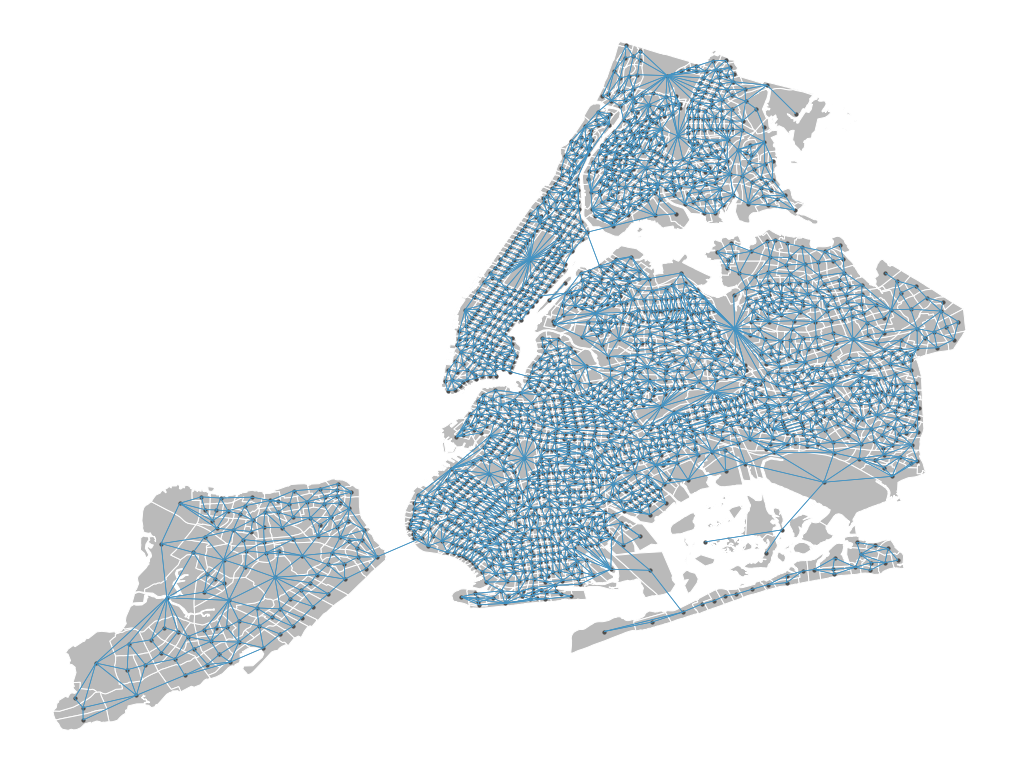

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 24))

plot_spatial_weights(wgt_unioned, nyctracts, ax=ax)

Let's double check that we have no disconnected components (i.e., that all components are connected).

In [12]:
from networkx.algorithms import components

nx_graph = wgt_unioned.to_networkx()
components.number_connected_components(nx_graph)

1

There is only one connected component, so we're good.

In [13]:
from cartoframes.viz import category_widget

X = nyctracts[["latitude", "longitude"]].values

ward = AgglomerativeClustering(
    n_clusters=16, connectivity=wgt_unioned.sparse, linkage="ward"
).fit(X)

nyctracts["label_structured_connected"] = [str(l).zfill(2) for l in ward.labels_]

Layer(nyctracts, 
      style = color_category_style('label_structured_connected',top=16),
      legends=color_category_legend(title="Agglomerative Clustering Labels",
                                   description="Full Connectivity"),
      widgets=[
          category_widget('label_structured_connected',
                          title='Cluster labels',
                          description='Select a category to filter')]
)

### How do the regions compare?

- In area?
- In population?

In [14]:
nyctracts.columns

Index(['cartodb_id', 'geoid', 'median_income_2011_2015', 'total_pop_2011_2015',
       'longitude', 'latitude', 'geometry', 'county_fips',
       'label_unstructured', 'label_structured_islands',
       'label_structured_connected'],
      dtype='object')

[Text(0, 0.5, 'Area (square kilometers)'), Text(0.5, 0, 'Cluster Label')]

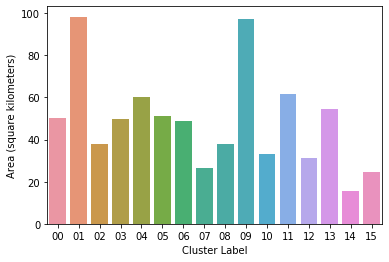

In [15]:
import seaborn as sns

areas = (
    pd.DataFrame(
        {
            "area": (
                nyctracts.to_crs({"init": "epsg:2263"}).geometry.area
                / (3280.84 * 3280.84)
            ),
            "total_pop_2011_2015": nyctracts.total_pop_2011_2015,
            "label_structured_connected": nyctracts.label_structured_connected,
        }
    )
    .groupby("label_structured_connected")
    .sum()
    .reset_index()
)

ax = sns.barplot(data=areas, x="label_structured_connected", y="area")
ax.set(xlabel="Cluster Label", ylabel="Area (square kilometers)")

[Text(0, 0.5, 'Population'), Text(0.5, 0, 'Cluster Label')]

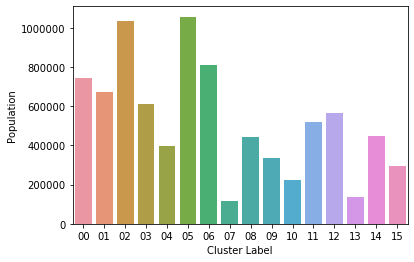

In [16]:
ax = sns.barplot(data=areas, x="label_structured_connected", y="total_pop_2011_2015")
ax.set(xlabel="Cluster Label", ylabel="Population")